In [1]:
import keras
from keras import layers
import random
import numpy as np
import tensorflow as tf

seed = 99
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

original_dimension = 3
encoded_dimension = 2

# create the layers of the model
input_vector = keras.Input(shape=(original_dimension,))
encoded = layers.Dense(encoded_dimension, activation='relu')(input_vector)
decoded = layers.Dense(original_dimension, activation='sigmoid')(encoded)

# create the model mapping the input and its reconstruction
autoencoder = keras.Model(input_vector, decoded)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense (Dense)               (None, 2)                 8         
                                                                 
 dense_1 (Dense)             (None, 3)                 9         
                                                                 
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________


In [2]:
# create a model for the encoder
encoder = keras.Model(input_vector, encoded)

# and one for the decoder
encoded_input = keras.Input(shape=(encoded_dimension,))
decoder_layer = autoencoder.layers[-1]
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

# now we compile the model with the optimizer and loss
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [3]:
import pandas as pd

# read synthetic data
data = pd.read_csv('datasets/real_life_regressor.csv')
data.head()

,h_1,h_2,x_1,x_2,x_3,y
0,-0.507907,-0.426783,-0.348796,-0.156770,-0.197266,0
1,0.208406,0.579240,-0.049915,-0.135873,-0.057563,1
2,-0.408581,0.486722,-0.734377,-0.359439,-0.515557,1
3,-0.686362,0.810403,-0.127156,0.049691,-0.722663,1
4,-0.270678,0.418167,-0.747838,-0.360587,-0.447434,1


In [4]:
# create training and validation set
observations = data[['x_1', 'x_2', 'x_3']]
training_set = observations.iloc[:750, :].to_numpy()
validation_set = observations.iloc[750:, :].to_numpy()

# and now we train the autoencoder
autoencoder.fit(training_set, training_set,
                epochs=500,
                batch_size=64,
                shuffle=True,
                validation_data=(validation_set, validation_set))

Epoch 1/500
12/12 [==============================] - 1s 23ms/step - loss: 0.7064 - val_loss: 0.7029
Epoch 2/500
12/12 [==============================] - 0s 8ms/step - loss: 0.6972 - val_loss: 0.6940
Epoch 3/500
12/12 [==============================] - 0s 6ms/step - loss: 0.6884 - val_loss: 0.6853
Epoch 4/500
12/12 [==============================] - 0s 5ms/step - loss: 0.6798 - val_loss: 0.6770
Epoch 5/500
12/12 [==============================] - 0s 4ms/step - loss: 0.6715 - val_loss: 0.6688
Epoch 6/500
12/12 [==============================] - 0s 5ms/step - loss: 0.6635 - val_loss: 0.6609
Epoch 7/500
12/12 [==============================] - 0s 4ms/step - loss: 0.6556 - val_loss: 0.6532
Epoch 8/500
12/12 [==============================] - 0s 5ms/step - loss: 0.6479 - val_loss: 0.6456
Epoch 9/500
12/12 [==============================] - 0s 7ms/step - loss: 0.6403 - val_loss: 0.6382
Epoch 10/500
12/12 [==============================] - 0s 7ms/step - loss: 0.6329 - val_loss: 0.6309
Epoch 11

In [5]:
# create the latent representations of the data
z = encoder.predict(observations.to_numpy()).T
data['z_1'] = z[0]
data['z_2'] = z[1]

data

,h_1,h_2,x_1,x_2,x_3,y,z_1,z_2
0,-0.507907,-0.426783,-0.348796,-0.156770,-0.197266,0,12.530251,0.000000
1,0.208406,0.579240,-0.049915,-0.135873,-0.057563,1,9.211573,0.470352
2,-0.408581,0.486722,-0.734377,-0.359439,-0.515557,1,19.174109,0.000000
3,-0.686362,0.810403,-0.127156,0.049691,-0.722663,1,14.096041,0.000000
4,-0.270678,0.418167,-0.747838,-0.360587,-0.447434,1,18.695078,0.000000
...,...,...,...,...,...,...,...,...
995,-0.459596,-0.513566,-0.230339,-0.197124,-0.142681,0,11.552031,0.000000
996,0.353899,0.330092,0.481501,0.140985,0.080699,1,2.614529,1.803656
997,-0.221661,-0.488341,0.028726,-0.115426,-0.013636,0,8.176119,0.698690
998,-0.308154,0.301733,-0.730905,-0.398765,-0.322134,1,17.780859,0.000000


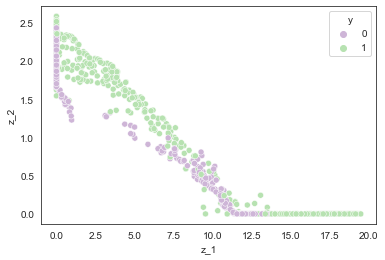

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# style for the plots
sns.set_style('white')
sns.set_palette('PRGn', 2)
sns.scatterplot(data=data, x='z_1', y='z_2', hue='y')
plt.savefig('figures/autoencoder_latent_space.png', dpi=250)
plt.show()

In [7]:
from representation_learning.metrics import multiple_correlation

print(f"autoencoder: {multiple_correlation(data, 'y', ['z_1', 'z_2']):.2f}")

autoencoder: 0.42


In [8]:
from representation_learning.metrics import mutual_information_gap

print(f"autoencoder: {mutual_information_gap(data, ['h_1', 'h_2'], ['z_1', 'z_2']):.2f}")

autoencoder: 0.19


In [9]:
from representation_learning.metrics import inverted_kruskals_stress

print(f"autoencoder: {inverted_kruskals_stress(data, ['x_1', 'x_2', 'x_3'], ['z_1', 'z_2'], 0.001):.2f}")

Search Range: [0.20000, 5.00000]


  0%|          | 0/10 [00:00<?, ?it/s]

Inverted Stress: -0.136, New Window Size: 0.73333
Search Range: [0.00000, 0.73333]


  0%|          | 0/10 [00:00<?, ?it/s]

Inverted Stress: 0.793, New Window Size: 0.16296
Search Range: [0.00000, 0.16296]


  0%|          | 0/10 [00:00<?, ?it/s]

Inverted Stress: 0.833, New Window Size: 0.03621
Search Range: [0.07243, 0.10864]


  0%|          | 0/10 [00:00<?, ?it/s]

Inverted Stress: 0.836, New Window Size: 0.00805
Search Range: [0.08852, 0.09657]


  0%|          | 0/10 [00:00<?, ?it/s]

Inverted Stress: 0.836, New Window Size: 0.00179
Search Range: [0.09299, 0.09478]


  0%|          | 0/10 [00:00<?, ?it/s]

Inverted Stress: 0.836, New Window Size: 0.00040
autoencoder: 0.84


In [10]:
data.to_csv('datasets/encoded_latent.csv', index=False)